In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import albumentations as A
import gc

import torch as tch
import torchvision.transforms as trf
from keras.utils import to_categorical
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification ,ConvNextImageProcessor
from transformers import DeiTImageProcessor, DeiTForImageClassificationWithTeacher



from torch.nn.parameter import Parameter
# import torch_xla
# import torch_xla.core.xla_model as xm

device = tch.device("cuda" if tch.cuda.is_available() else "cpu")

In [2]:
train_df = pd.read_csv('../input/drs-retino/train.csv')

In [3]:
contrast_root = '../input/diabetic-retinopathy-train/contrast/contrast/'
enh_root = '../input/diabetic-retinopathy-train/enhance-001/enhance/'
croped_root = '../input/diabetic-retinopathy-train/croped-002/croped/'

# EDA

<AxesSubplot:xlabel='target', ylabel='Count'>

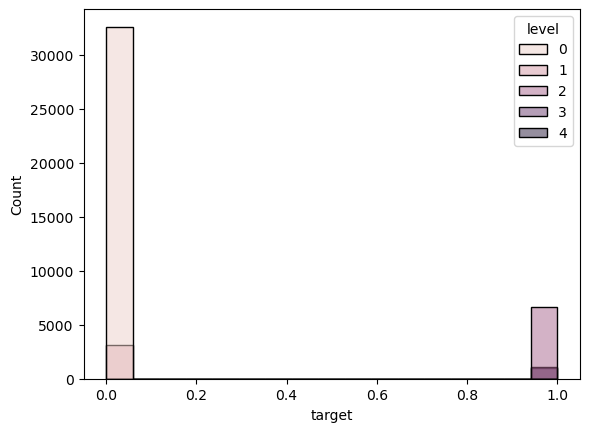

In [4]:
sns.histplot(data = train_df, x = 'target', hue = 'level')

<AxesSubplot:xlabel='level', ylabel='Count'>

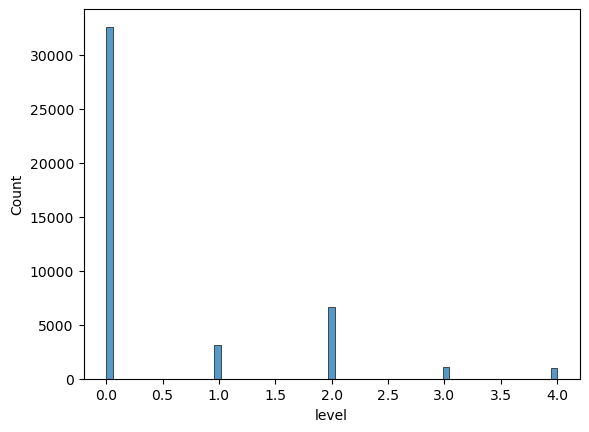

In [5]:
sns.histplot(data = train_df, x = 'level')

In [6]:
print('Target count :')
print( f'Target | 0 | = {train_df[train_df.target == 0].shape[0]} samples' )
print( f'Target | 1 | = {train_df[train_df.target == 1].shape[0]} samples' )
print('-------------------------------')

print('Level count :')
print( f'Level | 0 | = {train_df[train_df.level == 0].shape[0]} samples' )
print( f'Level | 1 | = {train_df[train_df.level == 1].shape[0]} samples' )
print( f'Level | 2 | = {train_df[train_df.level == 2].shape[0]} samples' )
print( f'Level | 3 | = {train_df[train_df.level == 3].shape[0]} samples' )
print( f'Level | 4 | = {train_df[train_df.level == 4].shape[0]} samples' )
print('-------------------------------')
print(f'Total sample : {train_df.shape[0]}')

Target count :
Target | 0 | = 35706 samples
Target | 1 | = 8637 samples
-------------------------------
Level count :
Level | 0 | = 32575 samples
Level | 1 | = 3131 samples
Level | 2 | = 6626 samples
Level | 3 | = 1059 samples
Level | 4 | = 952 samples
-------------------------------
Total sample : 44343


# Static Down Sampling

## Add level 0 and 2 more 

<AxesSubplot:xlabel='level', ylabel='Count'>

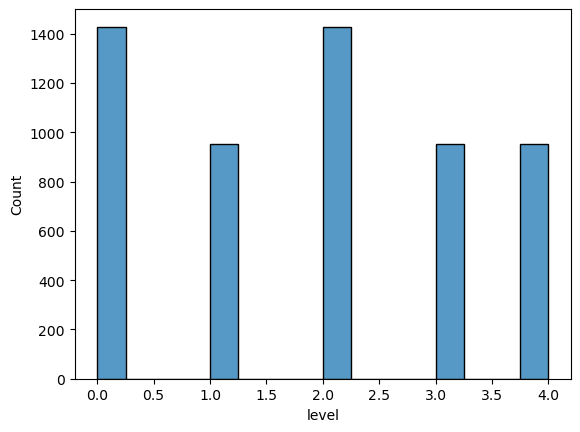

In [7]:
df_archive = []
lowest = 952
for i in range(train_df.level.nunique()):
    df = train_df[train_df.level == i][:lowest]
    if i == 0 or i == 2:
        df = train_df[train_df.level == i][:int(lowest * 1.5)]
    df_archive.append(df)
    
train_df = pd.concat(df_archive)
sns.histplot(data = train_df, x = 'level')

In [8]:
train_df

filename  level  target
0       im_1000.png      0       0
1      im_10000.png      0       0
2      im_10001.png      0       0
4      im_10005.png      0       0
5      im_10007.png      0       0
...             ...    ...     ...
43923     im_92.png      4       1
44061   im_9477.png      4       1
44178   im_9688.png      4       1
44239   im_9809.png      4       1
44309    im_994.png      4       1

[5712 rows x 3 columns]

[505 904 431  32]


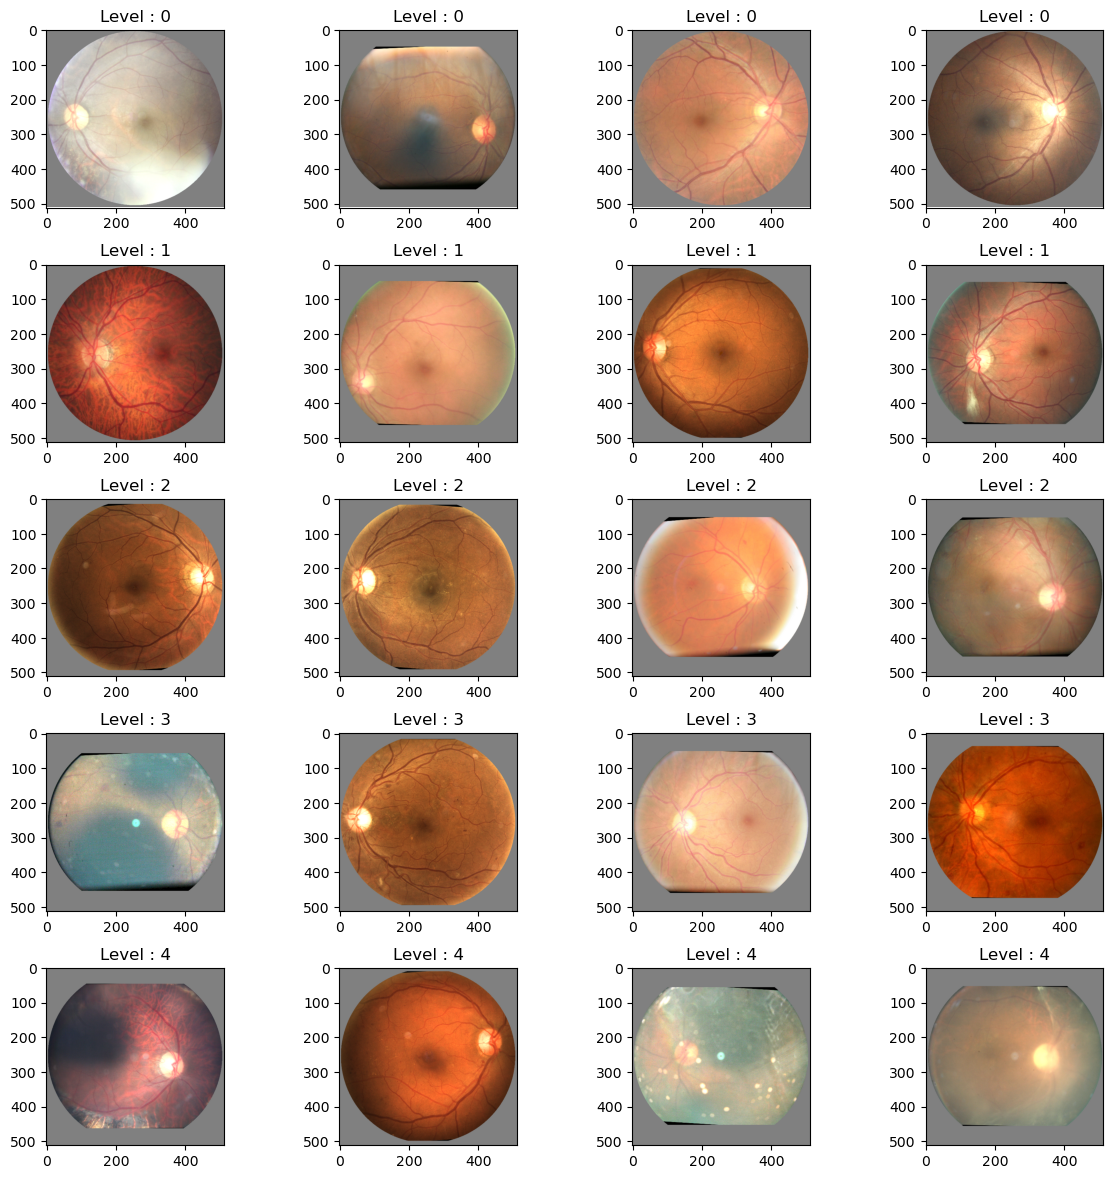

In [9]:
fig_size = (12,12)
rand_arr = np.random.randint(0,952,4)
print(rand_arr)

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = croped_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

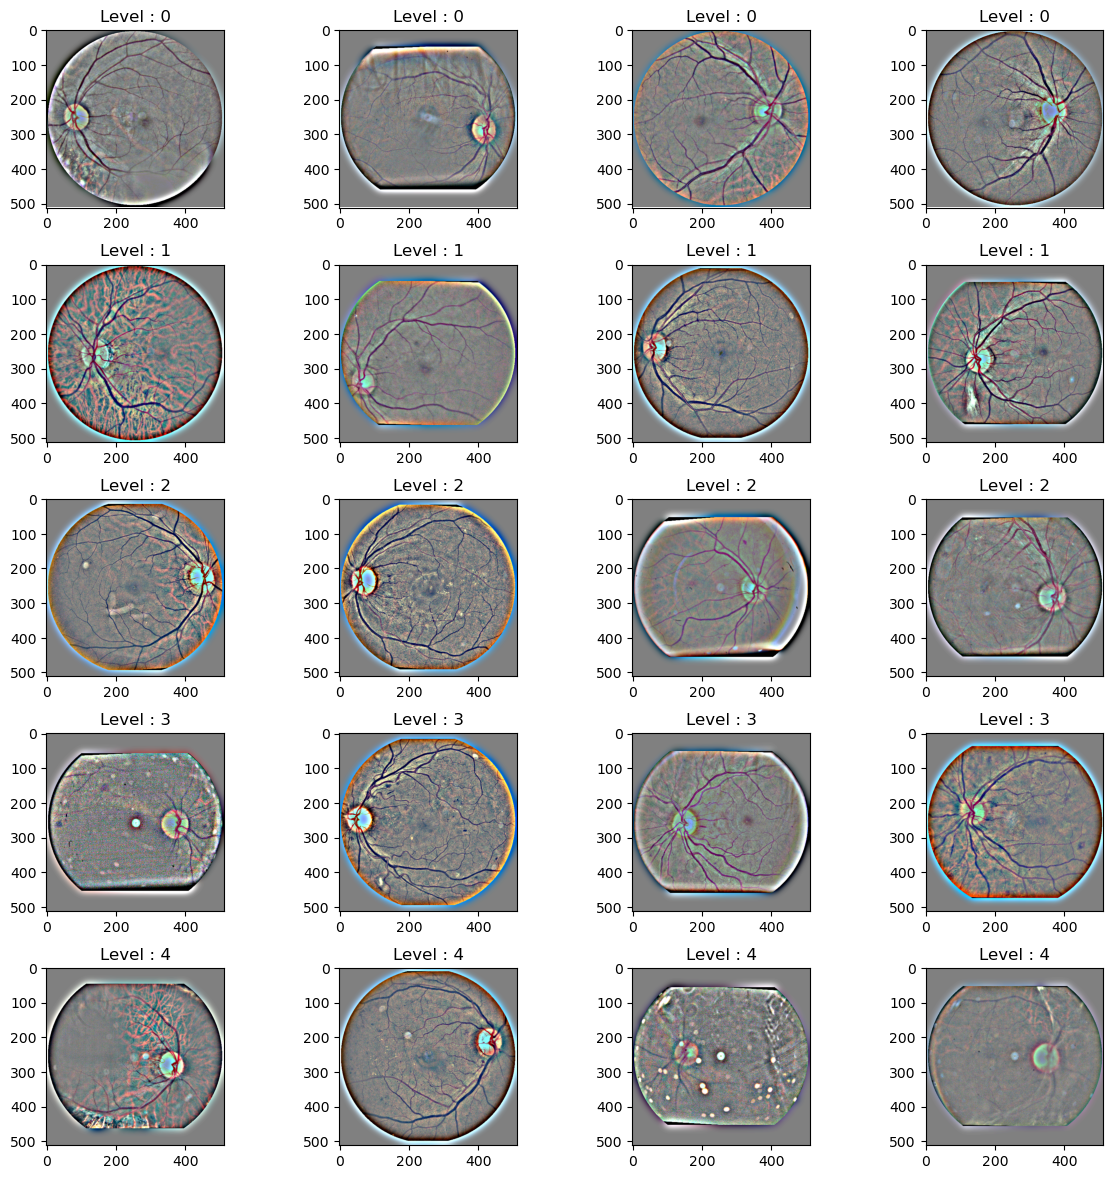

In [10]:

fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = contrast_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

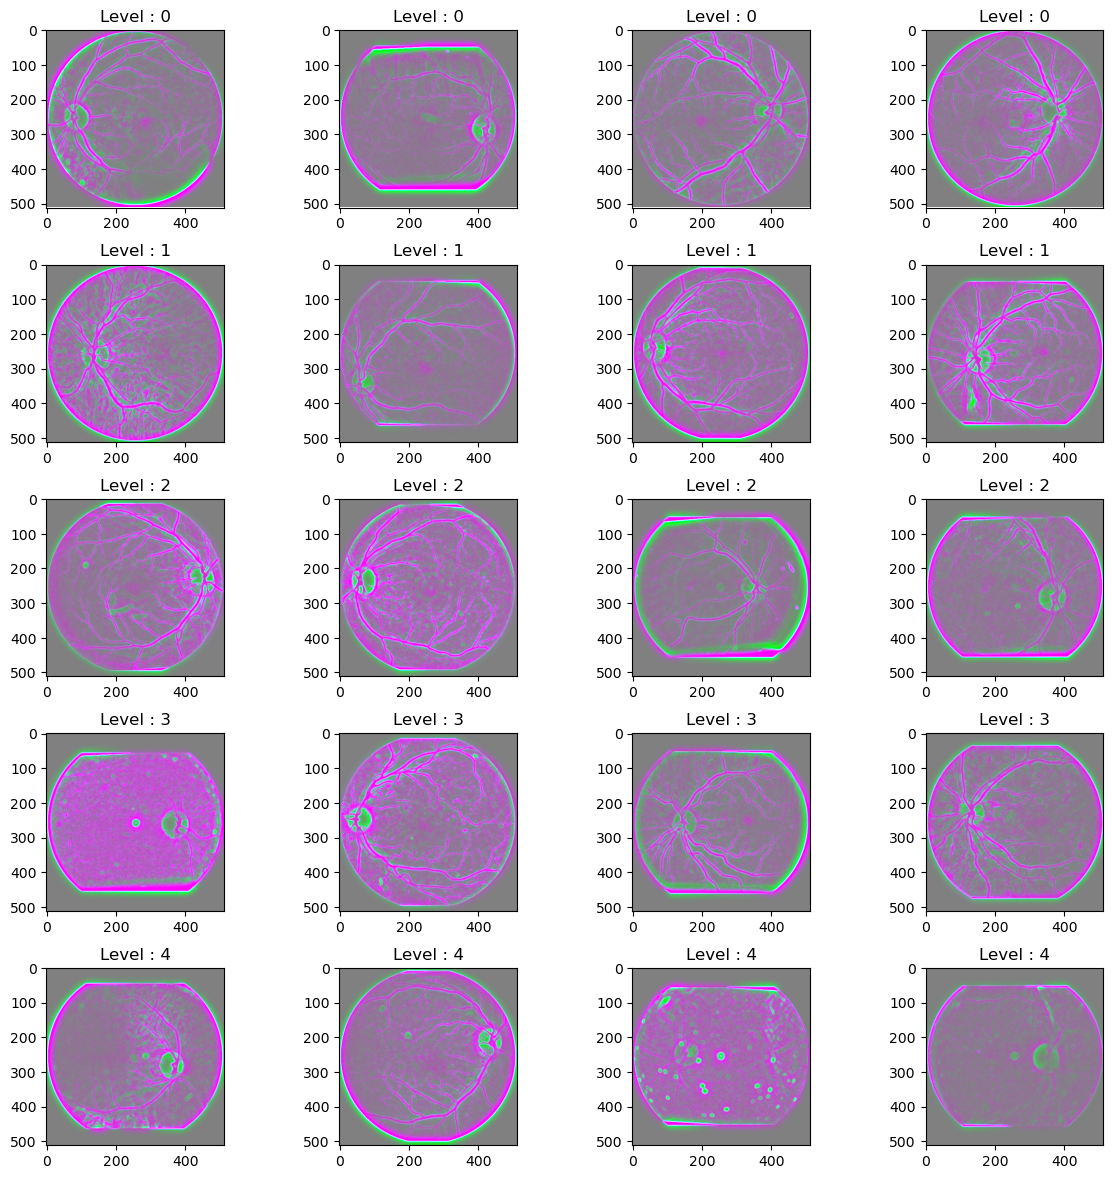

In [11]:
fig, axes = plt.subplots(5, 4, figsize=fig_size)
fig.tight_layout(pad=2.0)
for i in range(5):
    for j,img in enumerate(rand_arr):
        
        img_path = train_df[train_df.level == i].iloc[img,0]
        img_path = enh_root + img_path
        img_arr = cv2.imread(img_path)
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        
        ax = axes[i,j]
        ax.imshow(img_arr)
        ax.set_title(f'Level : {i}')

# Train test split

In [12]:
df_archive = []

for i in range(train_df.level.nunique()):
    df = train_df[train_df.level == i][:200]
    df_archive.append(df)
    
test = pd.concat(df_archive)

In [13]:
x = pd.concat([test,train_df])
dup = x.duplicated(keep = False)
train = x[~dup]
train = train.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Lion Optimizer

In [14]:
import torch
from torch.optim.optimizer import Optimizer

# functions

def exists(val):
    return val is not None

# update functions

def update_fn(p, grad, exp_avg, lr, wd, beta1, beta2):
    # stepweight decay

    p.data.mul_(1 - lr * wd)

    # weight update

    update = exp_avg.clone().mul_(beta1).add(grad, alpha = 1 - beta1).sign_()
    p.add_(update, alpha = -lr)

    # decay the momentum running average coefficient

    exp_avg.mul_(beta2).add_(grad, alpha = 1 - beta2)

# class

class Lion(Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        assert lr > 0.
        assert all([0. <= beta <= 1. for beta in betas])

        defaults = dict(
            lr = lr,
            betas = betas,
            weight_decay = weight_decay
        )

        super().__init__(params, defaults)

        self.update_fn = update_fn

    @torch.no_grad()
    def step(
        self,
        closure = None
    ):

        loss = None
        if exists(closure):
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: exists(p.grad), group['params']):

                grad, lr, wd, beta1, beta2, state = p.grad, group['lr'], group['weight_decay'], *group['betas'], self.state[p]

                # init state - exponential moving average of gradient values

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']

                self.update_fn(
                    p,
                    grad,
                    exp_avg,
                    lr,
                    wd,
                    beta1,
                    beta2
                )

        return loss

# Feed batch on fly ------

In [15]:
class BatchFeeder:
    def __init__(self, df,img_size, batch_size, root, transform = None, one_hot = True):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.root = root
        self.transform = transform
        self.one_hot = one_hot

        
    def feed(self,ib):
        batchX = []
        batchY = []
        df = self.df[int(ib*self.batch_size):int( (ib*self.batch_size) + self.batch_size )]
        for i in df.iterrows():
            img_path = self.root + i[1][0]
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            img_arr = cv2.resize(img_arr,(self.img_size,self.img_size))
            
            if self.transform:
                img_arr = self.transform( image = img_arr )['image'].astype(np.uint8)
            else:
                transform = A.Compose([
                    A.Normalize()], p = 1.0)
                img_arr = transform( image = img_arr )['image'].astype(np.uint8)
            
            if self.one_hot:
                batchY.append(to_categorical(i[1][1],num_classes = 5))
            else:
                batchY.append(i[1][1])
            
            batchX.append(img_arr)
        return tch.from_numpy(np.array(batchX).astype(np.float32)),\
                tch.from_numpy(np.array(batchY))
    
    def pic_div_255(self,img):
        return img / 255
    
    def arr_round(self,img):
        return np.round(img,5)

In [16]:
transform = A.Compose([
#     A.Blur( p = 0.2 ),
    A.Flip( p = 0.2 ),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.2),
    A.ShiftScaleRotate(p = 0.2),
    A.ElasticTransform( p = 0.2),
    A.Transpose(p = 0.2),
    A.GridDistortion(p = 0.2),
#     A.HueSaturationValue(5,5,5,p = 0.2 ),
    A.CLAHE( p = 0.2 ),
    A.Normalize()], 
    #A.CoarseDropout( p = 0.2 ),],
    p = 1.0)

# Modeling

In [17]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
model.classifier = tch.nn.Sequential(
    tch.nn.Linear(768,512),
    tch.nn.ReLU(),
    tch.nn.Linear(512,1024),
    tch.nn.Linear(1024,768),
    tch.nn.ReLU(),
    tch.nn.Linear(768,train_df.level.nunique()),
)

#

# model.classifier = tch.nn.Linear(768,train_df.level.nunique())
model= tch.nn.DataParallel(model)
model = model.to(device)

In [20]:
from sklearn.metrics import f1_score

In [21]:
def val_on_batch(model, img_size, batch_size, criterion, size = 0.1):
    df = test[:int(test.shape[0] * size)]
    stepsE = df.shape[0] // batch_size
    val_loss = 0
    val_acc = 0
    f1_val = 0
    for st in range(stepsE):
        model.eval()
        bfd_test = BatchFeeder(df,img_size,batch_size,enh_root).feed(st)
        x_inp = processor(bfd_test[0],return_tensors="pt")
        y_inp = bfd_test[1].to(device)

        with tch.no_grad():
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
#             print( y_inp.argmax(1).cpu().numpy().shape)
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy(), average = 'micro')
            
        f1_val += f1_ / stepsE
        val_loss += loss.item() / stepsE
        val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
    
    return val_loss,val_acc / df.shape[0],f1_val

In [22]:
def train_model(model,img_size,ep,batch_size,criterion,optimizer,scheduler,unfreeze_steps = 50):
    
    stepsT = train.shape[0] // batch_size
    stepsE = test.shape[0] // batch_size
#     Xtrain.to(device)
#     Xtest.to(device)
#     Ytrain.to(device)
#     Ytest.to(device)
    ###
    best_val = 0
    total_steps = 0
    ###
    
    for i in range(ep):
        print(f'Ep: {i+1}')
        
        train_loss = 0
        val_loss = 0
        
        train_acc = 0
        val_acc = 0
        
        train_f1 = 0
        val_f1 = 0
        ## Train
        for st in tqdm(range(stepsT)):
            model.train()
            # Prepare the Input
            bfd_train = BatchFeeder(train,img_size,batch_size,contrast_root,transform).feed(st)
            
            x_inp = processor(bfd_train[0], return_tensors="pt")
            y_inp = bfd_train[1].to(device)
            
            optimizer.zero_grad()
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy(), average = 'micro')
            
            loss.backward()
            optimizer.step()
            acc_ = tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
            train_loss += loss.item() / stepsT
            train_acc += acc_
            train_f1 += f1_ / stepsT
            
            if (st+1) % 50 == 0:
#                 print('Eval ---------------- Eval')
#                 ls,acc,f1 = val_on_batch(model, img_size, batch_size, criterion)
                print(f'Loss: {loss.item():.4f} | Acc: {acc_ / batch_size:.4f} | F1: {f1_:.4f}')
                
                if loss.item() < best_val:
                    tch.save(model,'/kaggle/working/checkpoint_hof.pth')
                    best_val = ls
            
            ## Unfreeze
            if total_steps+1 == unfreeze_steps:
                print('----------------Unfreezeeeeeeee-------------------')
                for p in model.parameters():
                    p.requires_grad = True
            
            scheduler.step()
            total_steps += 1
            
        tch.cuda.empty_cache()
        
        
        ## eval
        for st in tqdm(range(stepsE)):
            model.eval()
            # Prepare the Input
            bfd_test = BatchFeeder(test,img_size,batch_size,contrast_root).feed(st)
            
            x_inp = processor(bfd_test[0],return_tensors="pt")
            y_inp = bfd_test[1].to(device)
            
            out = model(**x_inp.to(device))
            loss = criterion(out.logits,y_inp)
            
            f1_ = f1_score(out.logits.argmax(1).cpu().numpy(), y_inp.argmax(1).cpu().numpy(), average = 'micro')
            val_f1 += f1_ / stepsE
            val_loss += loss.item() / stepsE
            val_acc += tch.sum(out.logits.argmax(1) == y_inp.argmax(1))
        
        tch.save(model,'/kaggle/working/checkpoint.pth')    
        print(f'Train loss: {train_loss:.4f} | Train acc: {(train_acc / train.shape[0]):.4f}')
        print(f'Val loss: {val_loss:.4f} | Val acc: {(val_acc / test.shape[0]):.4f}')
        print(f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}')

In [23]:
criterion = tch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = tch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-2)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = tch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [24]:
train_model(model,224,10,10,criterion,optimizer,scheduler,unfreeze_steps = 100)

Ep: 1


 11%|█         | 50/471 [00:32<03:13,  2.18it/s]

Loss: 1.6532 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 100/471 [00:55<02:40,  2.31it/s]

Loss: 1.5241 | Acc: 0.3000 | F1: 0.3000
----------------Unfreezeeeeeeee-------------------


 32%|███▏      | 150/471 [01:25<03:09,  1.69it/s]

Loss: 1.5483 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:55<02:35,  1.74it/s]

Loss: 1.4751 | Acc: 0.5000 | F1: 0.5000


 53%|█████▎    | 250/471 [02:24<02:04,  1.78it/s]

Loss: 1.5786 | Acc: 0.4000 | F1: 0.4000


 64%|██████▎   | 300/471 [02:54<01:42,  1.68it/s]

Loss: 1.6523 | Acc: 0.2000 | F1: 0.2000


 74%|███████▍  | 350/471 [03:24<01:09,  1.74it/s]

Loss: 1.6312 | Acc: 0.1000 | F1: 0.1000


 85%|████████▍ | 400/471 [03:54<00:40,  1.77it/s]

Loss: 1.5171 | Acc: 0.3000 | F1: 0.3000


 96%|█████████▌| 450/471 [04:24<00:13,  1.60it/s]

Loss: 1.6241 | Acc: 0.1000 | F1: 0.1000


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Train loss: 1.5567 | Train acc: 0.2808
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.2809 | Val F1: 0.2510
Ep: 2


 11%|█         | 50/471 [00:24<03:25,  2.05it/s]

Loss: 1.6027 | Acc: 0.1000 | F1: 0.1000


 21%|██        | 100/471 [00:49<03:21,  1.84it/s]

Loss: 1.5241 | Acc: 0.3000 | F1: 0.3000


 32%|███▏      | 150/471 [01:14<02:39,  2.01it/s]

Loss: 1.5442 | Acc: 0.4000 | F1: 0.4000


 42%|████▏     | 200/471 [01:41<02:38,  1.71it/s]

Loss: 1.5140 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 250/471 [02:07<01:48,  2.03it/s]

Loss: 1.5733 | Acc: 0.3000 | F1: 0.3000


 64%|██████▎   | 300/471 [02:33<01:36,  1.78it/s]

Loss: 1.7170 | Acc: 0.0000 | F1: 0.0000


 74%|███████▍  | 350/471 [02:59<01:06,  1.82it/s]

Loss: 1.6610 | Acc: 0.1000 | F1: 0.1000


 85%|████████▍ | 400/471 [03:25<00:33,  2.12it/s]

Loss: 1.4934 | Acc: 0.5000 | F1: 0.5000


 96%|█████████▌| 450/471 [03:51<00:10,  1.99it/s]

Loss: 1.6370 | Acc: 0.4000 | F1: 0.4000


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Train loss: 1.5435 | Train acc: 0.3039
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3040 | Val F1: 0.2510
Ep: 3


 11%|█         | 50/471 [00:26<03:45,  1.87it/s]

Loss: 1.6080 | Acc: 0.3000 | F1: 0.3000


 21%|██        | 100/471 [00:51<03:08,  1.97it/s]

Loss: 1.4722 | Acc: 0.6000 | F1: 0.6000


 32%|███▏      | 150/471 [01:16<02:47,  1.91it/s]

Loss: 1.5808 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:42<02:15,  2.00it/s]

Loss: 1.4774 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 250/471 [02:08<01:55,  1.92it/s]

Loss: 1.5815 | Acc: 0.3000 | F1: 0.3000


 64%|██████▎   | 300/471 [02:34<01:25,  2.00it/s]

Loss: 1.7060 | Acc: 0.0000 | F1: 0.0000


 74%|███████▍  | 350/471 [03:00<01:03,  1.91it/s]

Loss: 1.5822 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 400/471 [03:26<00:33,  2.09it/s]

Loss: 1.5133 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 450/471 [03:52<00:11,  1.81it/s]

Loss: 1.6175 | Acc: 0.1000 | F1: 0.1000


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Train loss: 1.5432 | Train acc: 0.3048
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3049 | Val F1: 0.2510
Ep: 4


 11%|█         | 50/471 [00:25<03:45,  1.87it/s]

Loss: 1.6437 | Acc: 0.1000 | F1: 0.1000


 21%|██        | 100/471 [00:51<03:03,  2.02it/s]

Loss: 1.4931 | Acc: 0.4000 | F1: 0.4000


 32%|███▏      | 150/471 [01:16<02:28,  2.16it/s]

Loss: 1.6237 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 200/471 [01:42<02:21,  1.92it/s]

Loss: 1.4701 | Acc: 0.5000 | F1: 0.5000


 53%|█████▎    | 250/471 [02:08<01:52,  1.97it/s]

Loss: 1.5790 | Acc: 0.1000 | F1: 0.1000


 64%|██████▎   | 300/471 [02:34<01:30,  1.88it/s]

Loss: 1.6045 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 350/471 [02:59<01:03,  1.91it/s]

Loss: 1.5628 | Acc: 0.3000 | F1: 0.3000


 85%|████████▍ | 400/471 [03:25<00:34,  2.03it/s]

Loss: 1.5111 | Acc: 0.3000 | F1: 0.3000


 96%|█████████▌| 450/471 [03:52<00:10,  1.94it/s]

Loss: 1.6187 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


Train loss: 1.5447 | Train acc: 0.2980
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.2981 | Val F1: 0.2510
Ep: 5


 11%|█         | 50/471 [00:25<03:19,  2.11it/s]

Loss: 1.5766 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 100/471 [00:50<03:13,  1.92it/s]

Loss: 1.5353 | Acc: 0.2000 | F1: 0.2000


 32%|███▏      | 150/471 [01:16<02:38,  2.03it/s]

Loss: 1.5489 | Acc: 0.4000 | F1: 0.4000


 42%|████▏     | 200/471 [01:42<02:15,  2.00it/s]

Loss: 1.4553 | Acc: 0.5000 | F1: 0.5000


 53%|█████▎    | 250/471 [02:08<01:44,  2.12it/s]

Loss: 1.5890 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 300/471 [02:33<01:29,  1.91it/s]

Loss: 1.7345 | Acc: 0.2000 | F1: 0.2000


 74%|███████▍  | 350/471 [03:00<00:59,  2.02it/s]

Loss: 1.6041 | Acc: 0.1000 | F1: 0.1000


 85%|████████▍ | 400/471 [03:26<00:35,  2.02it/s]

Loss: 1.5050 | Acc: 0.3000 | F1: 0.3000


 96%|█████████▌| 450/471 [03:52<00:12,  1.67it/s]

Loss: 1.6256 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Train loss: 1.5433 | Train acc: 0.3130
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3132 | Val F1: 0.2510
Ep: 6


 11%|█         | 50/471 [00:25<03:24,  2.06it/s]

Loss: 1.5726 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 100/471 [00:50<03:14,  1.91it/s]

Loss: 1.5469 | Acc: 0.1000 | F1: 0.1000


 32%|███▏      | 150/471 [01:16<02:49,  1.90it/s]

Loss: 1.5685 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 200/471 [01:42<02:19,  1.94it/s]

Loss: 1.4757 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 250/471 [02:08<01:55,  1.92it/s]

Loss: 1.5570 | Acc: 0.3000 | F1: 0.3000


 64%|██████▎   | 300/471 [02:34<01:40,  1.69it/s]

Loss: 1.7002 | Acc: 0.3000 | F1: 0.3000


 74%|███████▍  | 350/471 [02:58<01:04,  1.88it/s]

Loss: 1.6564 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 400/471 [03:25<00:32,  2.15it/s]

Loss: 1.5172 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 450/471 [03:50<00:10,  1.95it/s]

Loss: 1.6304 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Train loss: 1.5421 | Train acc: 0.3101
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3102 | Val F1: 0.2510
Ep: 7


 11%|█         | 50/471 [00:25<03:20,  2.10it/s]

Loss: 1.6038 | Acc: 0.3000 | F1: 0.3000


 21%|██        | 100/471 [00:51<03:28,  1.78it/s]

Loss: 1.5143 | Acc: 0.5000 | F1: 0.5000


 32%|███▏      | 150/471 [01:16<02:39,  2.01it/s]

Loss: 1.5773 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:42<02:04,  2.18it/s]

Loss: 1.4541 | Acc: 0.5000 | F1: 0.5000


 53%|█████▎    | 250/471 [02:08<01:53,  1.95it/s]

Loss: 1.5784 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 300/471 [02:34<01:32,  1.85it/s]

Loss: 1.6898 | Acc: 0.1000 | F1: 0.1000


 74%|███████▍  | 350/471 [02:59<01:03,  1.92it/s]

Loss: 1.6757 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 400/471 [03:25<00:39,  1.82it/s]

Loss: 1.5003 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 450/471 [03:50<00:10,  2.06it/s]

Loss: 1.6313 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Train loss: 1.5415 | Train acc: 0.3132
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3134 | Val F1: 0.2510
Ep: 8


 11%|█         | 50/471 [00:25<03:40,  1.91it/s]

Loss: 1.6201 | Acc: 0.3000 | F1: 0.3000


 21%|██        | 100/471 [00:51<03:41,  1.67it/s]

Loss: 1.5492 | Acc: 0.5000 | F1: 0.5000


 32%|███▏      | 150/471 [01:16<02:39,  2.01it/s]

Loss: 1.5913 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:42<02:16,  1.98it/s]

Loss: 1.4827 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 250/471 [02:07<01:56,  1.90it/s]

Loss: 1.5643 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 300/471 [02:33<01:25,  1.99it/s]

Loss: 1.6772 | Acc: 0.1000 | F1: 0.1000


 74%|███████▍  | 350/471 [02:58<01:03,  1.91it/s]

Loss: 1.5420 | Acc: 0.3000 | F1: 0.3000


 85%|████████▍ | 400/471 [03:24<00:36,  1.94it/s]

Loss: 1.5351 | Acc: 0.1000 | F1: 0.1000


 96%|█████████▌| 450/471 [03:49<00:09,  2.16it/s]

Loss: 1.6100 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Train loss: 1.5426 | Train acc: 0.3035
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3036 | Val F1: 0.2510
Ep: 9


 11%|█         | 50/471 [00:26<03:56,  1.78it/s]

Loss: 1.6588 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 100/471 [00:51<03:22,  1.84it/s]

Loss: 1.5193 | Acc: 0.5000 | F1: 0.5000


 32%|███▏      | 150/471 [01:17<02:36,  2.05it/s]

Loss: 1.5430 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:43<02:18,  1.95it/s]

Loss: 1.4742 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 250/471 [02:09<01:51,  1.98it/s]

Loss: 1.5651 | Acc: 0.4000 | F1: 0.4000


 64%|██████▎   | 300/471 [02:34<01:31,  1.87it/s]

Loss: 1.6787 | Acc: 0.3000 | F1: 0.3000


 74%|███████▍  | 350/471 [02:59<01:09,  1.75it/s]

Loss: 1.5660 | Acc: 0.1000 | F1: 0.1000


 85%|████████▍ | 400/471 [03:25<00:39,  1.81it/s]

Loss: 1.5050 | Acc: 0.3000 | F1: 0.3000


 96%|█████████▌| 450/471 [03:51<00:10,  2.08it/s]

Loss: 1.6405 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Train loss: 1.5399 | Train acc: 0.3105
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3106 | Val F1: 0.2510
Ep: 10


 11%|█         | 50/471 [00:26<03:39,  1.92it/s]

Loss: 1.5743 | Acc: 0.3000 | F1: 0.3000


 21%|██        | 100/471 [00:51<03:18,  1.87it/s]

Loss: 1.4738 | Acc: 0.6000 | F1: 0.6000


 32%|███▏      | 150/471 [01:17<02:44,  1.95it/s]

Loss: 1.5666 | Acc: 0.3000 | F1: 0.3000


 42%|████▏     | 200/471 [01:42<02:13,  2.02it/s]

Loss: 1.4986 | Acc: 0.3000 | F1: 0.3000


 53%|█████▎    | 250/471 [02:07<01:52,  1.97it/s]

Loss: 1.5713 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 300/471 [02:34<01:44,  1.64it/s]

Loss: 1.6836 | Acc: 0.2000 | F1: 0.2000


 74%|███████▍  | 350/471 [03:00<01:01,  1.98it/s]

Loss: 1.5768 | Acc: 0.3000 | F1: 0.3000


 85%|████████▍ | 400/471 [03:26<00:40,  1.76it/s]

Loss: 1.5386 | Acc: 0.3000 | F1: 0.3000


 96%|█████████▌| 450/471 [03:52<00:11,  1.89it/s]

Loss: 1.6703 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


Train loss: 1.5433 | Train acc: 0.2967
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.2968 | Val F1: 0.2510


In [25]:
train_model(model,224,10,5,criterion,optimizer,scheduler,unfreeze_steps = 100)

Ep: 1


  5%|▌         | 50/942 [00:16<04:30,  3.29it/s]

Loss: 1.7447 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:42,  2.98it/s]

Loss: 1.4883 | Acc: 0.4000 | F1: 0.4000
----------------Unfreezeeeeeeee-------------------


 16%|█▌        | 150/942 [00:48<04:29,  2.94it/s]

Loss: 1.5688 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:04<03:53,  3.18it/s]

Loss: 1.4365 | Acc: 0.6000 | F1: 0.6000


 27%|██▋       | 250/942 [01:20<03:32,  3.26it/s]

Loss: 1.6766 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<02:53,  3.71it/s]

Loss: 1.5980 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:52<02:46,  3.56it/s]

Loss: 1.6294 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 400/942 [02:08<02:48,  3.22it/s]

Loss: 1.4750 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:25<02:39,  3.09it/s]

Loss: 1.6584 | Acc: 0.2000 | F1: 0.2000


 53%|█████▎    | 500/942 [02:41<02:17,  3.21it/s]

Loss: 1.8580 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:57<02:14,  2.92it/s]

Loss: 1.4997 | Acc: 0.4000 | F1: 0.4000


 64%|██████▎   | 600/942 [03:13<01:51,  3.08it/s]

Loss: 1.8257 | Acc: 0.2000 | F1: 0.2000


 69%|██████▉   | 650/942 [03:29<01:29,  3.28it/s]

Loss: 1.5950 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:46<01:13,  3.28it/s]

Loss: 1.5055 | Acc: 0.4000 | F1: 0.4000


 80%|███████▉  | 750/942 [04:02<00:59,  3.21it/s]

Loss: 1.5983 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:18<00:43,  3.29it/s]

Loss: 1.6422 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:34<00:29,  3.13it/s]

Loss: 1.5269 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 900/942 [04:50<00:12,  3.42it/s]

Loss: 1.7368 | Acc: 0.2000 | F1: 0.2000


100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


Train loss: 1.5419 | Train acc: 0.3081
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3083 | Val F1: 0.2510
Ep: 2


  5%|▌         | 50/942 [00:16<05:17,  2.81it/s]

Loss: 1.7288 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:31<04:16,  3.28it/s]

Loss: 1.5159 | Acc: 0.4000 | F1: 0.4000


 16%|█▌        | 150/942 [00:47<03:51,  3.42it/s]

Loss: 1.5564 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:04<03:46,  3.28it/s]

Loss: 1.4073 | Acc: 0.4000 | F1: 0.4000


 27%|██▋       | 250/942 [01:21<03:22,  3.42it/s]

Loss: 1.8117 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<03:20,  3.20it/s]

Loss: 1.5898 | Acc: 0.4000 | F1: 0.4000


 37%|███▋      | 350/942 [01:52<03:08,  3.13it/s]

Loss: 1.6283 | Acc: 0.0000 | F1: 0.0000


 42%|████▏     | 400/942 [02:08<02:50,  3.18it/s]

Loss: 1.4912 | Acc: 0.2000 | F1: 0.2000


 48%|████▊     | 450/942 [02:25<02:40,  3.07it/s]

Loss: 1.6501 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 500/942 [02:40<02:13,  3.32it/s]

Loss: 1.7933 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:56<02:04,  3.14it/s]

Loss: 1.5346 | Acc: 0.0000 | F1: 0.0000


 64%|██████▎   | 600/942 [03:13<01:45,  3.23it/s]

Loss: 1.8592 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:29<01:39,  2.92it/s]

Loss: 1.5405 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:45<01:20,  3.00it/s]

Loss: 1.5419 | Acc: 0.4000 | F1: 0.4000


 80%|███████▉  | 750/942 [04:01<01:13,  2.63it/s]

Loss: 1.5643 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:18<00:44,  3.21it/s]

Loss: 1.5962 | Acc: 0.2000 | F1: 0.2000


 90%|█████████ | 850/942 [04:34<00:27,  3.29it/s]

Loss: 1.5448 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 900/942 [04:50<00:12,  3.50it/s]

Loss: 1.7620 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


Train loss: 1.5418 | Train acc: 0.3075
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3076 | Val F1: 0.2510
Ep: 3


  5%|▌         | 50/942 [00:16<05:06,  2.91it/s]

Loss: 1.6805 | Acc: 0.2000 | F1: 0.2000


 11%|█         | 100/942 [00:32<04:32,  3.09it/s]

Loss: 1.4870 | Acc: 0.4000 | F1: 0.4000


 16%|█▌        | 150/942 [00:47<04:02,  3.26it/s]

Loss: 1.5284 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:03<03:52,  3.19it/s]

Loss: 1.4771 | Acc: 0.4000 | F1: 0.4000


 27%|██▋       | 250/942 [01:19<03:36,  3.20it/s]

Loss: 1.6956 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<03:27,  3.10it/s]

Loss: 1.5749 | Acc: 0.0000 | F1: 0.0000


 37%|███▋      | 350/942 [01:52<02:48,  3.50it/s]

Loss: 1.6651 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 400/942 [02:08<02:56,  3.06it/s]

Loss: 1.4688 | Acc: 0.2000 | F1: 0.2000


 48%|████▊     | 450/942 [02:24<02:58,  2.76it/s]

Loss: 1.6200 | Acc: 0.2000 | F1: 0.2000


 53%|█████▎    | 500/942 [02:40<02:34,  2.86it/s]

Loss: 1.7970 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:57<01:55,  3.38it/s]

Loss: 1.4650 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 600/942 [03:14<02:21,  2.42it/s]

Loss: 1.9033 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:30<01:31,  3.20it/s]

Loss: 1.5948 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:46<01:17,  3.10it/s]

Loss: 1.5125 | Acc: 0.4000 | F1: 0.4000


 80%|███████▉  | 750/942 [04:02<01:04,  2.97it/s]

Loss: 1.6255 | Acc: 0.0000 | F1: 0.0000


 85%|████████▍ | 800/942 [04:18<00:45,  3.14it/s]

Loss: 1.6081 | Acc: 0.2000 | F1: 0.2000


 90%|█████████ | 850/942 [04:34<00:26,  3.50it/s]

Loss: 1.5640 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 900/942 [04:50<00:11,  3.55it/s]

Loss: 1.7781 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.79it/s]


Train loss: 1.5414 | Train acc: 0.3094
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3096 | Val F1: 0.2510
Ep: 4


  5%|▌         | 50/942 [00:16<04:49,  3.08it/s]

Loss: 1.7304 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:47,  2.92it/s]

Loss: 1.5998 | Acc: 0.0000 | F1: 0.0000


 16%|█▌        | 150/942 [00:49<04:08,  3.19it/s]

Loss: 1.5612 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:05<03:43,  3.32it/s]

Loss: 1.4832 | Acc: 0.2000 | F1: 0.2000


 27%|██▋       | 250/942 [01:21<03:42,  3.11it/s]

Loss: 1.7416 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:37<03:14,  3.30it/s]

Loss: 1.6397 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:53<03:13,  3.05it/s]

Loss: 1.6345 | Acc: 0.4000 | F1: 0.4000


 42%|████▏     | 400/942 [02:08<02:34,  3.52it/s]

Loss: 1.4648 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:25<02:36,  3.15it/s]

Loss: 1.6237 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 500/942 [02:40<02:13,  3.31it/s]

Loss: 1.7881 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:57<01:56,  3.36it/s]

Loss: 1.5931 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 600/942 [03:13<02:00,  2.84it/s]

Loss: 1.8956 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:30<01:44,  2.80it/s]

Loss: 1.5949 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:46<01:17,  3.14it/s]

Loss: 1.5347 | Acc: 0.2000 | F1: 0.2000


 80%|███████▉  | 750/942 [04:03<00:57,  3.31it/s]

Loss: 1.5974 | Acc: 0.4000 | F1: 0.4000


 85%|████████▍ | 800/942 [04:18<00:51,  2.76it/s]

Loss: 1.5831 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:35<00:35,  2.61it/s]

Loss: 1.5906 | Acc: 0.0000 | F1: 0.0000


 96%|█████████▌| 900/942 [04:50<00:13,  3.06it/s]

Loss: 1.8548 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


Train loss: 1.5435 | Train acc: 0.3054
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3055 | Val F1: 0.2510
Ep: 5


  5%|▌         | 50/942 [00:16<04:21,  3.41it/s]

Loss: 1.6979 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:40,  3.00it/s]

Loss: 1.5057 | Acc: 0.2000 | F1: 0.2000


 16%|█▌        | 150/942 [00:48<04:00,  3.30it/s]

Loss: 1.5796 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 200/942 [01:04<03:36,  3.42it/s]

Loss: 1.4819 | Acc: 0.2000 | F1: 0.2000


 27%|██▋       | 250/942 [01:19<03:43,  3.10it/s]

Loss: 1.7091 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<03:18,  3.23it/s]

Loss: 1.6099 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:53<03:15,  3.02it/s]

Loss: 1.6065 | Acc: 0.0000 | F1: 0.0000


 42%|████▏     | 400/942 [02:10<03:46,  2.40it/s]

Loss: 1.4718 | Acc: 0.6000 | F1: 0.6000


 48%|████▊     | 450/942 [02:26<02:37,  3.12it/s]

Loss: 1.6268 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 500/942 [02:42<02:29,  2.95it/s]

Loss: 1.7803 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:58<02:10,  2.99it/s]

Loss: 1.4931 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 600/942 [03:15<01:41,  3.38it/s]

Loss: 1.9281 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:30<01:48,  2.69it/s]

Loss: 1.5889 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:46<01:10,  3.45it/s]

Loss: 1.6415 | Acc: 0.2000 | F1: 0.2000


 80%|███████▉  | 750/942 [04:03<01:01,  3.12it/s]

Loss: 1.6194 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:19<00:44,  3.20it/s]

Loss: 1.6195 | Acc: 0.2000 | F1: 0.2000


 90%|█████████ | 850/942 [04:34<00:27,  3.29it/s]

Loss: 1.5318 | Acc: 0.2000 | F1: 0.2000


 96%|█████████▌| 900/942 [04:51<00:12,  3.45it/s]

Loss: 1.8235 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.91it/s]


Train loss: 1.5438 | Train acc: 0.3039
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3040 | Val F1: 0.2510
Ep: 6


  5%|▌         | 50/942 [00:15<04:40,  3.18it/s]

Loss: 1.6919 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:28,  3.14it/s]

Loss: 1.5743 | Acc: 0.2000 | F1: 0.2000


 16%|█▌        | 150/942 [00:48<04:19,  3.05it/s]

Loss: 1.5744 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:04<04:29,  2.75it/s]

Loss: 1.5021 | Acc: 0.4000 | F1: 0.4000


 27%|██▋       | 250/942 [01:20<03:24,  3.39it/s]

Loss: 1.7619 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<02:54,  3.68it/s]

Loss: 1.5964 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:52<03:01,  3.26it/s]

Loss: 1.6586 | Acc: 0.4000 | F1: 0.4000


 42%|████▏     | 400/942 [02:08<03:01,  2.98it/s]

Loss: 1.4636 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:24<02:29,  3.28it/s]

Loss: 1.6531 | Acc: 0.2000 | F1: 0.2000


 53%|█████▎    | 500/942 [02:39<02:08,  3.45it/s]

Loss: 1.8012 | Acc: 0.0000 | F1: 0.0000


 58%|█████▊    | 550/942 [02:55<01:56,  3.37it/s]

Loss: 1.5250 | Acc: 0.0000 | F1: 0.0000


 64%|██████▎   | 600/942 [03:11<02:01,  2.83it/s]

Loss: 1.8375 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:27<01:33,  3.13it/s]

Loss: 1.5499 | Acc: 0.6000 | F1: 0.6000


 74%|███████▍  | 700/942 [03:43<01:26,  2.80it/s]

Loss: 1.4905 | Acc: 0.2000 | F1: 0.2000


 80%|███████▉  | 750/942 [03:59<01:00,  3.18it/s]

Loss: 1.5979 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:15<00:41,  3.38it/s]

Loss: 1.6293 | Acc: 0.2000 | F1: 0.2000


 90%|█████████ | 850/942 [04:31<00:30,  3.02it/s]

Loss: 1.5540 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 900/942 [04:47<00:13,  3.18it/s]

Loss: 1.8486 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.86it/s]


Train loss: 1.5443 | Train acc: 0.3003
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3004 | Val F1: 0.2510
Ep: 7


  5%|▌         | 50/942 [00:16<05:31,  2.69it/s]

Loss: 1.7193 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:41,  2.99it/s]

Loss: 1.5140 | Acc: 0.2000 | F1: 0.2000


 16%|█▌        | 150/942 [00:48<04:07,  3.19it/s]

Loss: 1.5892 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:03<04:11,  2.95it/s]

Loss: 1.4988 | Acc: 0.2000 | F1: 0.2000


 27%|██▋       | 250/942 [01:20<04:06,  2.80it/s]

Loss: 1.6971 | Acc: 0.2000 | F1: 0.2000


 32%|███▏      | 300/942 [01:36<03:25,  3.12it/s]

Loss: 1.5985 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:51<03:05,  3.20it/s]

Loss: 1.6450 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 400/942 [02:08<02:46,  3.26it/s]

Loss: 1.4921 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:24<03:02,  2.70it/s]

Loss: 1.6405 | Acc: 0.2000 | F1: 0.2000


 53%|█████▎    | 500/942 [02:40<02:20,  3.15it/s]

Loss: 1.8082 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:56<02:07,  3.08it/s]

Loss: 1.5002 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 600/942 [03:12<01:52,  3.05it/s]

Loss: 1.8193 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:28<01:31,  3.20it/s]

Loss: 1.5142 | Acc: 0.2000 | F1: 0.2000


 74%|███████▍  | 700/942 [03:45<01:28,  2.75it/s]

Loss: 1.5298 | Acc: 0.0000 | F1: 0.0000


 80%|███████▉  | 750/942 [04:01<00:59,  3.22it/s]

Loss: 1.6517 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:18<00:47,  2.97it/s]

Loss: 1.6101 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:34<00:28,  3.20it/s]

Loss: 1.5540 | Acc: 0.2000 | F1: 0.2000


 96%|█████████▌| 900/942 [04:51<00:13,  3.22it/s]

Loss: 1.8497 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.82it/s]


Train loss: 1.5441 | Train acc: 0.3058
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3059 | Val F1: 0.2510
Ep: 8


  5%|▌         | 50/942 [00:16<05:21,  2.77it/s]

Loss: 1.7656 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:27,  3.14it/s]

Loss: 1.5627 | Acc: 0.2000 | F1: 0.2000


 16%|█▌        | 150/942 [00:48<04:25,  2.99it/s]

Loss: 1.5599 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:04<04:09,  2.98it/s]

Loss: 1.4241 | Acc: 0.4000 | F1: 0.4000


 27%|██▋       | 250/942 [01:20<03:39,  3.16it/s]

Loss: 1.6663 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<03:25,  3.13it/s]

Loss: 1.5558 | Acc: 0.2000 | F1: 0.2000


 37%|███▋      | 350/942 [01:52<03:21,  2.93it/s]

Loss: 1.6693 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 400/942 [02:08<02:52,  3.15it/s]

Loss: 1.4704 | Acc: 0.2000 | F1: 0.2000


 48%|████▊     | 450/942 [02:25<02:55,  2.80it/s]

Loss: 1.6684 | Acc: 0.2000 | F1: 0.2000


 53%|█████▎    | 500/942 [02:40<02:03,  3.57it/s]

Loss: 1.8434 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:57<02:07,  3.09it/s]

Loss: 1.5794 | Acc: 0.0000 | F1: 0.0000


 64%|██████▎   | 600/942 [03:13<01:43,  3.32it/s]

Loss: 1.9012 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:30<01:36,  3.02it/s]

Loss: 1.6174 | Acc: 0.2000 | F1: 0.2000


 74%|███████▍  | 700/942 [03:46<01:16,  3.17it/s]

Loss: 1.5101 | Acc: 0.4000 | F1: 0.4000


 80%|███████▉  | 750/942 [04:03<01:05,  2.95it/s]

Loss: 1.5823 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:19<00:50,  2.81it/s]

Loss: 1.6098 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:35<00:28,  3.18it/s]

Loss: 1.5675 | Acc: 0.2000 | F1: 0.2000


 96%|█████████▌| 900/942 [04:51<00:13,  3.19it/s]

Loss: 1.7735 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


Train loss: 1.5415 | Train acc: 0.3035
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3036 | Val F1: 0.2510
Ep: 9


  5%|▌         | 50/942 [00:15<04:44,  3.14it/s]

Loss: 1.7061 | Acc: 0.0000 | F1: 0.0000


 11%|█         | 100/942 [00:32<04:32,  3.09it/s]

Loss: 1.5555 | Acc: 0.2000 | F1: 0.2000


 16%|█▌        | 150/942 [00:48<04:03,  3.25it/s]

Loss: 1.5505 | Acc: 0.2000 | F1: 0.2000


 21%|██        | 200/942 [01:04<04:31,  2.74it/s]

Loss: 1.4636 | Acc: 0.6000 | F1: 0.6000


 27%|██▋       | 250/942 [01:19<03:15,  3.54it/s]

Loss: 1.6831 | Acc: 0.0000 | F1: 0.0000


 32%|███▏      | 300/942 [01:36<03:27,  3.09it/s]

Loss: 1.6179 | Acc: 0.0000 | F1: 0.0000


 37%|███▋      | 350/942 [01:52<03:18,  2.98it/s]

Loss: 1.6803 | Acc: 0.2000 | F1: 0.2000


 42%|████▏     | 400/942 [02:08<02:51,  3.15it/s]

Loss: 1.5179 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:24<02:23,  3.42it/s]

Loss: 1.6462 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 500/942 [02:40<02:26,  3.02it/s]

Loss: 1.8020 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [02:56<02:07,  3.06it/s]

Loss: 1.4424 | Acc: 0.2000 | F1: 0.2000


 64%|██████▎   | 600/942 [03:11<01:39,  3.43it/s]

Loss: 1.8505 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:27<01:36,  3.04it/s]

Loss: 1.5471 | Acc: 0.4000 | F1: 0.4000


 74%|███████▍  | 700/942 [03:44<01:26,  2.80it/s]

Loss: 1.5533 | Acc: 0.4000 | F1: 0.4000


 80%|███████▉  | 750/942 [04:01<01:02,  3.07it/s]

Loss: 1.5796 | Acc: 0.2000 | F1: 0.2000


 85%|████████▍ | 800/942 [04:18<00:45,  3.12it/s]

Loss: 1.5986 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:34<00:30,  2.99it/s]

Loss: 1.5503 | Acc: 0.4000 | F1: 0.4000


 96%|█████████▌| 900/942 [04:50<00:12,  3.45it/s]

Loss: 1.8587 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Train loss: 1.5448 | Train acc: 0.3109
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3110 | Val F1: 0.2510
Ep: 10


  5%|▌         | 50/942 [00:16<04:58,  2.99it/s]

Loss: 1.6892 | Acc: 0.2000 | F1: 0.2000


 11%|█         | 100/942 [00:32<04:08,  3.38it/s]

Loss: 1.5189 | Acc: 0.0000 | F1: 0.0000


 16%|█▌        | 150/942 [00:48<03:52,  3.40it/s]

Loss: 1.5464 | Acc: 0.4000 | F1: 0.4000


 21%|██        | 200/942 [01:05<03:34,  3.46it/s]

Loss: 1.4935 | Acc: 0.6000 | F1: 0.6000


 27%|██▋       | 250/942 [01:22<03:44,  3.08it/s]

Loss: 1.6851 | Acc: 0.2000 | F1: 0.2000


 32%|███▏      | 300/942 [01:39<03:31,  3.03it/s]

Loss: 1.5787 | Acc: 0.4000 | F1: 0.4000


 37%|███▋      | 350/942 [01:55<02:54,  3.38it/s]

Loss: 1.6462 | Acc: 0.4000 | F1: 0.4000


 42%|████▏     | 400/942 [02:11<02:40,  3.37it/s]

Loss: 1.4581 | Acc: 0.4000 | F1: 0.4000


 48%|████▊     | 450/942 [02:28<02:52,  2.85it/s]

Loss: 1.6402 | Acc: 0.4000 | F1: 0.4000


 53%|█████▎    | 500/942 [02:45<02:35,  2.85it/s]

Loss: 1.7545 | Acc: 0.2000 | F1: 0.2000


 58%|█████▊    | 550/942 [03:01<02:11,  2.97it/s]

Loss: 1.5026 | Acc: 0.0000 | F1: 0.0000


 64%|██████▎   | 600/942 [03:17<01:38,  3.48it/s]

Loss: 1.8944 | Acc: 0.0000 | F1: 0.0000


 69%|██████▉   | 650/942 [03:33<01:37,  3.01it/s]

Loss: 1.5613 | Acc: 0.6000 | F1: 0.6000


 74%|███████▍  | 700/942 [03:49<01:13,  3.31it/s]

Loss: 1.5759 | Acc: 0.2000 | F1: 0.2000


 80%|███████▉  | 750/942 [04:06<01:04,  2.99it/s]

Loss: 1.5546 | Acc: 0.6000 | F1: 0.6000


 85%|████████▍ | 800/942 [04:21<00:41,  3.45it/s]

Loss: 1.6121 | Acc: 0.4000 | F1: 0.4000


 90%|█████████ | 850/942 [04:38<00:28,  3.22it/s]

Loss: 1.5635 | Acc: 0.2000 | F1: 0.2000


 96%|█████████▌| 900/942 [04:54<00:12,  3.37it/s]

Loss: 1.7861 | Acc: 0.0000 | F1: 0.0000


100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Train loss: 1.5414 | Train acc: 0.3014
Val loss: 1.5901 | Val acc: 0.2510
Train F1: 0.3015 | Val F1: 0.2510
